## Train vehicle detection classifier

In [28]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

SAVE_IMAGES = True

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def standartize(im):
    mu = np.mean(im)
    sd = np.std(im)
    return (im - mu) / max(sd, 1.0/len(im))

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), img_draw=None, cls=(0,0,0)):
    # If x and/or y start/stop positions not defined, set to image size

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            if SAVE_IMAGES:
                cv2.rectangle(img_draw, (startx, starty), (endx, endy), cls, 2)

    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_NN(imgs, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    l = len(imgs)
    idx = 0
    # Iterate through the list of images
    for file in imgs:
        if idx%100 == 0:
            print(str(idx) + 'out of ' + str(l))
        idx = idx + 1
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                _, hog_image = get_hog_features(feature_image[:,:,channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=True, feature_vec=True)
                feature_image[:,:,channel] = hog_image
            # Append the new feature vector to the features list
            features.append(feature_image)
        else:
            _, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
            features.append(hog_image)
                
    # Return list of feature vectors
    return features


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, nn_clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, nn=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        nn_prediction = 1.0
        if nn:
            for channel in range(test_img.shape[2]):
                _, im = get_hog_features(
                    test_img[:,:,channel], orient, pix_per_cell, cell_per_block, 
                    vis=True, feature_vec=True)
                test_img[:,:,channel] = im
            im = np.expand_dims(test_img, axis=0)
            nn_prediction = nn_clf.predict(im)        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    


/home/carnd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using TensorFlow backend.


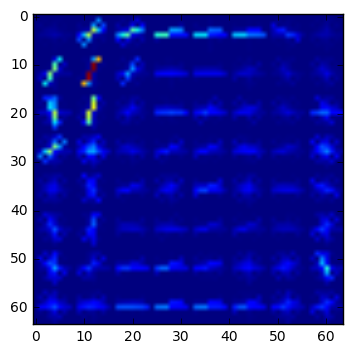

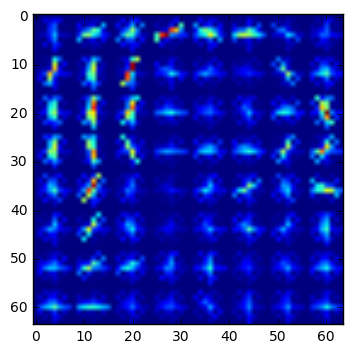

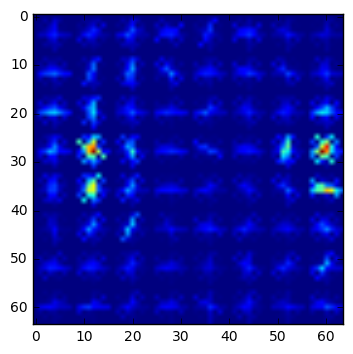

In [3]:
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Read in cars and notcars
cars = []
notcars = []

car_globs = [
#    glob.glob('./images/object-dataset/*.png'),      
    glob.glob('./images/vehicles/GTI_Far/*.png'),
    glob.glob('./images/vehicles/GTI_Right/*.png'),
    glob.glob('./images/vehicles/GTI_MiddleClose/*.png'),
    glob.glob('./images/vehicles/GTI_Left/*.png'),
    glob.glob('./images/vehicles/KITTI_extracted/*.png')
]
non_car_globs = [
    glob.glob('./images/non-vehicles/Extras/*.png'),
    glob.glob('./images/non-vehicles/GTI/*.png')
]
        
csv_file = './object-dataset/labels.csv'

for images in car_globs:
    for image in images:
        cars.append(image)    

for images in non_car_globs:
    for image in images:
        notcars.append(image)     

# save some data exploration images
im_car = mpimg.imread(cars[0])
mpimg.imsave('./output_images/car.jpg', im_car)
im_notcar = mpimg.imread(notcars[0])
mpimg.imsave('./output_images/notcar.jpg', im_notcar)

hog_img = np.zeros_like(im_car).astype(np.float)
im_car = cv2.cvtColor(im_car, cv2.COLOR_RGB2YUV)

_, hog_img[:,:,0] = get_hog_features(
    im_car[:,:,0], orient=18, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
_, hog_img[:,:,1] = get_hog_features(
    im_car[:,:,1], orient=18, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
_, hog_img[:,:,2] = get_hog_features(
    im_car[:,:,2], orient=18, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

mpimg.imsave('./output_images/HOG_example.jpg', 255*hog_img)

plt.figure()
plt.imshow(hog_img[:,:,0])
plt.savefig('./output_images/HOG_example_0.jpg')
plt.figure()
plt.imshow(hog_img[:,:,1])
plt.savefig('./output_images/HOG_example_1.jpg')
plt.figure()
plt.imshow(hog_img[:,:,2])
plt.savefig('./output_images/HOG_example_2.jpg')

def process_udacity_images():
    labels=[]
    with open(csv_file, 'rt') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=' ')
        for row in reader:
            # if not occluded and is car
            if row['label'] == "car" and row['occluded'] == '0':
                #print(row['label'])
                xmin = int(row['xmin'])
                xmax = int(row['xmax'])
                ymin = int(row['ymin'])
                ymax = int(row['ymax'])
                #print(row['fname'], xmin, xmax, ymin, ymax)

                image = mpimg.imread('./object-dataset/'+row['fname'])
                #print(xmin,xmax,ymin,ymax)
                fname = row['fname'].replace('jpg', 'png')
                dest = cv2.resize(image[ymin:ymax, xmin:xmax, :], (64, 64))
                mpimg.imsave('./images/object-dataset/'+fname, dest)    

def train_svm():
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc, X_scaler

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Cropping2D, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

def VGG_16():
    model = Sequential()

    model.add(Convolution2D(4, 5, 5, activation='relu', input_shape=(64,64,3)))
    
    model.add(Convolution2D(4, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(16, 5, 5, activation='relu'))
    model.add(Convolution2D(16, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model



def train_nn():
    car_features = extract_features_NN(cars, color_space=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features_NN(notcars, color_space=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    X_NN = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Define the labels vector
    y_NN = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X_NN, y_NN, test_size=0.2, random_state=rand_state)
    
    print('Feature vector length:', len(X_train[0]))    
    # compile and train the model using the generator function
    
    train_samples = X_train
    validation_samples = X_test
    
    model = VGG_16()
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=15)    
    model.save('model.h5')
    
#process_udacity_images()

## Define SVM parameters and train the classifier

In [4]:
#### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

svc, X_scaler = train_svm()

#train_nn()

Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 13752
9.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9887


## Define heatmap, threshold functions and general pipeline


In [61]:
from scipy.ndimage.measurements import label
from shapely.geometry import Polygon

%matplotlib inline

y_start_stop = [300, 600] # Min and max in y to search in slide_window()

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def filter_out_non_road(road_lane, bbox_list):
    # Iterate through list of bboxes
    out_boxes = []
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        p1 = box[0]
        p2 = box[1]
        
        box_poly = Polygon(
            [(p1[1], p1[0]),
             (p2[1], p1[0]),
             (p2[1], p2[0]), 
             (p1[1], p2[0])])
        if road_lane.intersects(box_poly):
            out_boxes.append(box)
            
    return out_boxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def road_region():

    src = np.float32([
            [200,720],
            [650,430],
            [1100,430],
            [1280, 490],
            [1280,720]])

    return Polygon(src)

def draw_labeled_bboxes(img, road_lane, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        p1 = bbox[0]
        p2 = bbox[1]
        
        box_poly = Polygon(
            [(p1[0], p1[1]),
             (p2[0], p1[1]),
             (p2[0], p2[1]), 
             (p1[0], p2[1])])

        # only account boxes which intersects the region
        # of interest (i.e the road)
        # this way we can filter out some false positives
        if road_lane.intersects(box_poly):
            print(box_poly)
            print(road_lane)
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from keras.models import load_model
nn_model_clf = load_model('model.h5')

from collections import deque

FRAME_QUEUE_SIZE = 10
hot_queue = deque(maxlen=FRAME_QUEUE_SIZE)
road_poly = road_region()

def detect_vehicles(image):
    hot_queue.clear()
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)

    wnd_sizes = [(64,64), (96, 128), (96, 96), (128, 128)]
    
    hot_windows = []
    dr_image = np.copy(image)
    dr_image = dr_image.astype(np.float32)/255

    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]
    for wnd_sz, cls in zip(wnd_sizes, colors):
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=wnd_sz, xy_overlap=(0.5, 0.5), img_draw=dr_image, cls=cls)

    # Return the list of windows
        wnds = search_windows(image, windows, svc, nn_model_clf, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat, nn=False)     
        hot_windows.extend(wnds)

    if SAVE_IMAGES:
        mpimg.imsave('./output_images/sliding_windows.jpg', dr_image*255)
    hot_queue.append(hot_windows)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    hw = []
    # add all the heat map windows in the last 10 frames
    for hot in hot_queue:
        hw += hot
    
    heat = add_heat(heat,hw)
    
    print(np.max(heat))
            
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1.0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)        

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(draw_image, road_poly, labels)
    
    if SAVE_IMAGES:
        global counter
        mpimg.imsave('./output_images/heatmap' + str(counter) + '.jpg', heatmap)
        labels_output = np.zeros_like(image[:,:,0]).astype(np.float)
        labels = label(heatmap, output=labels_output)
        mpimg.imsave('./output_images/labels' + str(counter) + '.jpg', labels_output)
        mpimg.imsave('./output_images/final_frame' + str(counter) + '.jpg', draw_img)

    counter = counter + 1
    
    return draw_img
    
def save_report_images():
    image = mpimg.imread('./test_images/test1.jpg')
    img = detect_vehicles(image)
    plt.figure()
    plt.imshow(img)
    mpimg.imsave('./output_images/test_result1.jpg', img)

    image = mpimg.imread('./test_images/test2.jpg')
    img = detect_vehicles(image)
    plt.figure()
    plt.imshow(img)
    mpimg.imsave('./output_images/test_result2.jpg', img)

    image = mpimg.imread('./test_images/test3.jpg')
    img = detect_vehicles(image)
    plt.figure()
    plt.imshow(img)
    mpimg.imsave('./output_images/test_result3.jpg', img)

    image = mpimg.imread('./test_images/test4.jpg')
    img = detect_vehicles(image)
    plt.figure()
    plt.imshow(img)
    mpimg.imsave('./output_images/test_result4.jpg', img)



In [62]:
#### Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
import numpy as np 
    
def process_image(image):
    return detect_vehicles(image)

output = 'test_videos_output/project_video.mp4'
videos = glob.glob('./project_video.mp4')
hot_queue.clear()
counter = 0

# Step through the list and search for chessboard corners
for video in videos:
    output = 'test_videos_output/' + video
    clip = VideoFileClip(video).subclip(29,29.5)
    if not os.path.exists('test_videos_output'):
        os.makedirs('test_videos_output')
    lane_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(output, audio=False)

3.0
POLYGON ((1056 364, 1215 364, 1215 555, 1056 555, 1056 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
[MoviePy] >>>> Building video test_videos_output/./project_video.mp4
[MoviePy] Writing video test_videos_output/./project_video.mp4



  0%|          | 0/13 [00:00<?, ?it/s]

3.0
POLYGON ((1056 364, 1215 364, 1215 555, 1056 555, 1056 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



  8%|▊         | 1/13 [00:05<01:01,  5.11s/it]

3.0
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((1056 396, 1247 396, 1247 555, 1056 555, 1056 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 15%|█▌        | 2/13 [00:10<00:58,  5.28s/it]

3.0
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((1056 396, 1279 396, 1279 555, 1056 555, 1056 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 23%|██▎       | 3/13 [00:15<00:51,  5.19s/it]

5.0
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((1056 396, 1279 396, 1279 555, 1056 555, 1056 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 31%|███       | 4/13 [00:21<00:48,  5.44s/it]

4.0
POLYGON ((1008 364, 1279 364, 1279 555, 1008 555, 1008 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 38%|███▊      | 5/13 [00:26<00:42,  5.30s/it]

5.0
POLYGON ((1056 364, 1279 364, 1279 587, 1056 587, 1056 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 46%|████▌     | 6/13 [00:31<00:36,  5.20s/it]

7.0
POLYGON ((1008 364, 1279 364, 1279 555, 1008 555, 1008 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 54%|█████▍    | 7/13 [00:37<00:32,  5.45s/it]

6.0
POLYGON ((1024 364, 1279 364, 1279 555, 1024 555, 1024 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 62%|██████▏   | 8/13 [00:42<00:26,  5.30s/it]

4.0
POLYGON ((1152 364, 1279 364, 1279 555, 1152 555, 1152 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 69%|██████▉   | 9/13 [00:47<00:20,  5.22s/it]

4.0
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((1008 396, 1279 396, 1279 587, 1008 587, 1008 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 77%|███████▋  | 10/13 [00:52<00:15,  5.15s/it]

7.0
POLYGON ((1008 364, 1279 364, 1279 587, 1008 587, 1008 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 85%|████████▍ | 11/13 [00:57<00:10,  5.08s/it]

7.0
POLYGON ((1008 364, 1279 364, 1279 587, 1008 587, 1008 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))
POLYGON ((864 396, 959 396, 959 491, 864 491, 864 396))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



 92%|█████████▏| 12/13 [01:02<00:05,  5.04s/it]

7.0
POLYGON ((864 364, 1279 364, 1279 587, 864 587, 864 364))
POLYGON ((200 720, 650 430, 1100 430, 1280 490, 1280 720, 200 720))



100%|██████████| 13/13 [01:07<00:00,  5.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/./project_video.mp4 

CPU times: user 4min 21s, sys: 9.17 s, total: 4min 30s
Wall time: 1min 8s
